# Lab 02 - Road Lines and Street Signs Detection with the Hough Transform

Computer Vision 2023-24 (M. Caligiuri, F. Lincetto, P. Zanuttigh)

In this lab you will explore the topic of line and circle detection using the Hough transform. In particular you will use this technique to segment the street lanes and the round street signs from the provided images.

---

## Import the necessary libraries

In [19]:
!pip install opencv-python --upgrade

In [20]:
# Import the necessary packages
%matplotlib inline

import typing as tp
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

---

## Define some auxiliary functions

Write here all the auxiliary functions you will need.
More precisely the following functions are provided:
- `show_img` -> given in input an image and optionally a title it will plot the image as a matplotlib plot performing also the necessary conversion from BGR to RGB,
- `polar2cartesian` -> given an array of angles and one of radius it will return the corresponding cartesian coordinates as numpy arrays,
- `draw_lines` -> given in input an image and a set of lines it will draw the lines on the image and return the resulting image,
- `fill_lines` -> given in input an image and the mask of the lines it will fill the lines with a given color and return the resulting image,
- `check_param` -> given a list of value in imput check that none of them is less or equal to 0, returns a list containing the same values apart from the negative ones that will be set to 1.

In [21]:
# Function to plot images inline in the notebook
def show_img(img, title=None):
    # Check if the image is in BGR format and convert it to RGB
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Plot the image
    plt.figure() 
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

In [22]:
# Function to perform the conversion between polar and cartesian coordinates
def polar2cartesian(radius: np.ndarray, angle: np.ndarray, cv2_setup: bool = True) -> np.ndarray:
    if cv2_setup:
        return radius * np.array([np.cos(angle), np.sin(angle)])
    else:
        return radius * np.array([np.sin(angle), np.cos(angle)])

In [23]:
def draw_lines(img: np.ndarray, lines: np.ndarray, color: tp.List[int] = [0, 0, 255], thickness: int = 1, cv_setup: bool = True) -> tp.Tuple[np.ndarray]:
    new_image = np.copy(img)
    empty_image = np.zeros(img.shape[:2])

    if len(lines.shape) == 3:  # Check if lines has the correct shape
        lines = lines[:, 0, :]  # Reshape lines to (num_lines, 2)

    # Draw found lines
    for rho, theta in lines:
        x0 = polar2cartesian(rho, theta, cv_setup)
        direction = np.array([x0[1], -x0[0]])
        pt1 = np.round(x0 + 1000*direction).astype(int)
        pt2 = np.round(x0 - 1000*direction).astype(int)
        empty_image = cv.line(img=empty_image, pt1=pt1, pt2=pt2, color=255, thickness=thickness)

    # Keep lower part of each line until intersection
    mask_lines = empty_image != 0
    min_diff = np.inf
    max_line = 0
    for i in range(mask_lines.shape[0]):
        line = mask_lines[i]
        indices = np.argwhere(line)
        if indices[-1] - indices[0] < min_diff:
            min_diff = indices[-1] - indices[0]
            max_line = i

    mask_boundaries = np.zeros_like(empty_image)
    mask_boundaries[max_line:] = 1
    mask = (mask_lines * mask_boundaries).astype(bool)

    new_image[mask] = np.array(color)
    
    return new_image, mask

In [24]:
# Function that given the image and the mask of the lines, fill the area between the lines
def fill_lines(img: np.ndarray, mask: np.ndarray, color: tp.List[int] = [0, 0, 255]) -> np.ndarray:
    border = np.where(mask)

    possible_vertex = np.where(border[0] == np.min(border[0]))
    vertex = np.array([border[0][int(len(possible_vertex[0]) / 2)], border[1][int(len(possible_vertex[0]) / 2)]])[::-1]

    possible_bottom = np.where(border[0] == np.max(border[0]))
    bottom_pos = [np.min(possible_bottom[0]), np.max(possible_bottom[0])]
    bottom_left = np.array([border[0][bottom_pos[0]], border[1][bottom_pos[0]]])[::-1]
    bottom_right = np.array([border[0][bottom_pos[1]], border[1][bottom_pos[1]]])[::-1]
    points = np.array([vertex, bottom_left, bottom_right])

    return cv.fillConvexPoly(np.copy(img), points=points, color=color)

In [25]:
check_params = lambda x: [i if i > 0 else 1 for i in x]

---

## Road lines Detection

In this section you have to implement the road detection using the Hough transform together with the Canny algorithm.

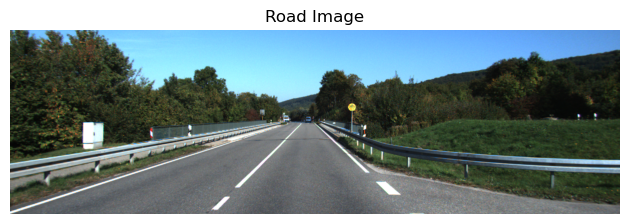

In [26]:
# Load image (img path './data/road2.png')
image_path = './data/road2.png' # ADD YOUR CODE HERE (remove None)
image = cv.imread(image_path)
# Show the image
# Suggestion: to show the image inline use the function show_img()
# ADD YOUR CODE HERE
show_img(image, title='Road Image')

### Edge extraction using the Canny algorithm

In [27]:
# Create a cv window with two trackbars to change the thresholds values of the Canny algorithm
# Using the trackbars choose the best thresholds values to extract the edges of the road
# Print also the best parameters
# ADD YOUR CODE HERE

def nothing(x):
    pass
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
blurred = cv.blur(gray, (3, 3))

# Creating a window
window_name = "Canny Edge Detection"
cv.namedWindow(window_name)



cv.createTrackbar("Threshold1", window_name, 400, 1000, nothing)
cv.createTrackbar("Threshold2", window_name, 200, 1000, nothing)

# Read the image

while True:
    # Get the current threshold values from the trackbars
    threshold1 = cv.getTrackbarPos("Threshold1", window_name)
    threshold2 = cv.getTrackbarPos("Threshold2", window_name)

    # Apply Canny edge detection to the image
    edges = cv.Canny(blurred, threshold1, threshold2,3)

    # Display the original image and the edges
    cv.imshow("Original", image)
    cv.imshow("Edges", edges)

    # Press 'q' to exit the loop
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Print the best threshold values
print("Best threshold1:", threshold1)
print("Best threshold2:", threshold2)

# Close all windows
cv.destroyAllWindows()


Best threshold1: 0
Best threshold2: 701


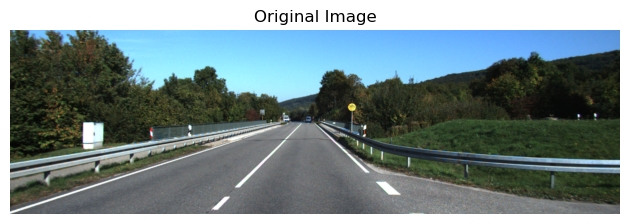

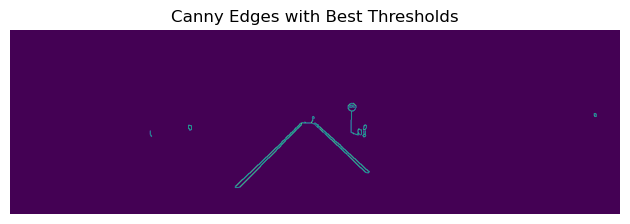

In [28]:
# Visualize the result of the Canny algorithm with the best thresholds values
# Suggestions: use the function show_img() and check that the edges are suitable for the next step (see the example on the slides)
# ADD YOUR CODE HERE
best_edges = cv.Canny(blurred, threshold1, threshold2,3)

# Visualize the result using the show_img() function
show_img(image, title="Original Image")
show_img(best_edges, title="Canny Edges with Best Thresholds")

### Hough transform to detect lines

In [29]:

# Create a window with a set of trackbars to change the parameters of the Hough transform
# Using the trackbars choose the best parameters to find the lines of the road
# ADD YOUR CODE HERE

# Set the best threshold values from Canny algorithm
best_threshold1 = 0
best_threshold2 = 701

# Apply Canny edge detection with the best thresholds
best_edges = cv.Canny(blurred, best_threshold1, best_threshold2,3)

# Create a window
window_name = "Hough Transform Parameters"
cv.namedWindow(window_name)



cv.createTrackbar("Rho", window_name, 1, 10, nothing)
cv.createTrackbar("Theta (in degrees)", window_name, 1, 3, nothing)
cv.createTrackbar("Threshold", window_name, 50, 200, nothing)

while True:
    # Get the current values from the trackbars
    rho = cv.getTrackbarPos("Rho", window_name)
    theta = np.radians(cv.getTrackbarPos("Theta (in degrees)", window_name))
    threshold =cv.getTrackbarPos("Threshold", window_name)

    # Apply Hough transform to detect lines
    lines = cv.HoughLinesP(best_edges, rho, theta, threshold)

    # Draw the lines on a copy of the original image
    lines_image = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv.line(lines_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Display the original image and the image with detected lines
    cv.imshow("Original Image", image)
    cv.imshow("Lines Detected", lines_image)

    # Press 'q' to exit the loop
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Close all windows
cv.destroyAllWindows()


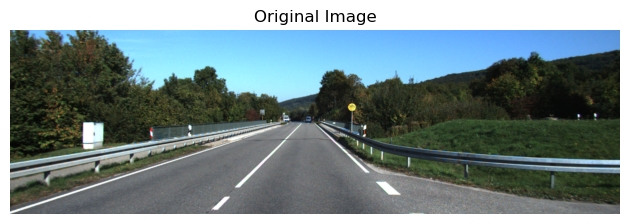

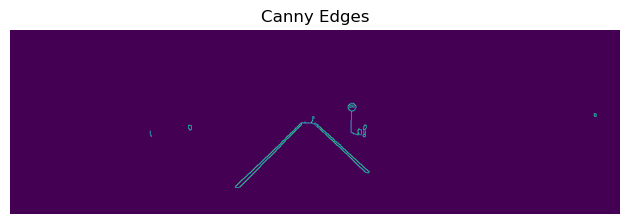

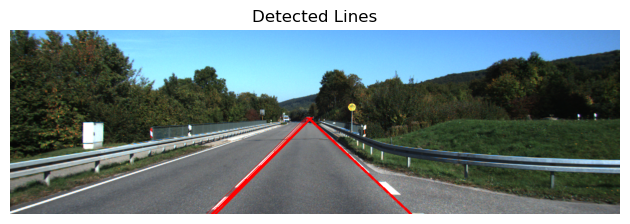

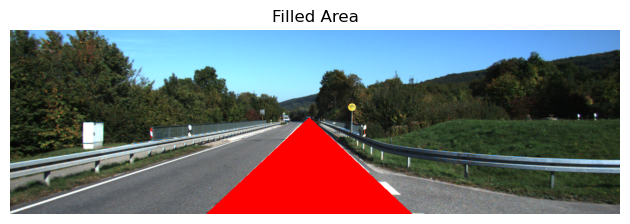

In [30]:
# Visualize the result of the Hough transform with the best parameters
# ADD YOUR CODE HERE
# Set the best parameters from the previous Hough transform code
# Parameters for Canny edge detection
canny_threshold1 = 0
canny_threshold2 = 701

# Apply Canny edge detection
edges = cv.Canny(blurred, canny_threshold1, canny_threshold2,3)

# Best Parameters for Hough line detection
rho = 1
theta = np.pi / 180
hough_threshold = 120

# Detect lines using HoughLines
lines = cv.HoughLines(edges, rho, theta, hough_threshold)

# Draw the detected lines on the original image
image_with_lines, mask= draw_lines(image, lines, color=[0, 0, 255], thickness=3)

image_filled = fill_lines(image, mask, color=[0, 0, 255])

# Display the results
show_img(image,'Original Image')
show_img(edges,'Canny Edges')
show_img(image_with_lines,'Detected Lines')
show_img(image_filled,'Filled Area')

cv.waitKey(0)
cv.destroyAllWindows()

### Custom implementation of the Hough Transform

Now try to implement the Hough transform by yourself. You can use the following steps as a guide:
1. Define the discretization of the parameter space (i.e. the accumulator) and initialize the accumulator matrix to zero,
2. For each edge point in the image:
    - For each angle in the discretization:
        1. Compute the corresponding radius,
        2. Increment the accumulator at the corresponding position,
3. Find the largest values in the accumulator,
4. Get the corresponding angle and radius,
5. Return the line corresponding to the angle and radius.

In [31]:
# Define a function to perform the Hough transform and return the lines found
def hough_lines_new(edges: np.ndarray, threshold: float, min_theta: float, max_theta: float) -> np.ndarray:


    # Initialize the counter matrix in polar coords
    # ADD YOUR CODE HERE
    height, width = edges.shape

    # Diagonal length of the image
    diag_len = np.ceil(np.sqrt(height**2 + width**2))


    # Define angular step
    # ADD YOUR CODE HERE
    
    theta_step = 1.0 
    rhos = np.arange(-diag_len, diag_len + 1, 1)
    thetas = np.deg2rad(np.arange(min_theta, max_theta, theta_step))
    num_thetas = len(thetas)
    accumulator = np.zeros((2 * len(rhos), num_thetas), dtype=int)

    # Consider edges only
    edge_coords = np.column_stack(np.where(edges > 0))


    # Update the counter
    # ADD YOUR CODE HERE
    for edge_point in edge_coords:
        for t_idx, theta in enumerate(thetas):
            rho = int(edge_point[1] * np.cos(theta) + edge_point[0] * np.sin(theta))
            rho_idx = np.argmin(np.abs(rhos - rho))
            accumulator[rho_idx, t_idx] += 1    
                           

    # Take the polar coords most matched
    # ADD YOUR CODE HERE
    row_indices, col_indices = np.where(accumulator > threshold)

    # Extract rhos and thetas based on indices
    rhos_found = rhos[row_indices]
    thetas_found = thetas[col_indices]

    # Convert rhos and thetas to Cartesian coordinates
    lines = np.column_stack((rhos_found, thetas_found))

    return lines

    pass

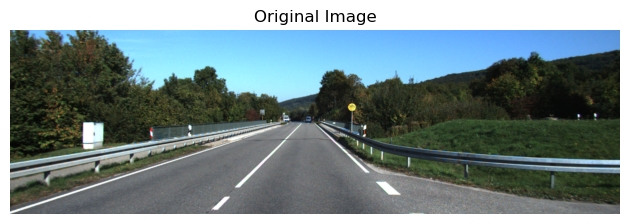

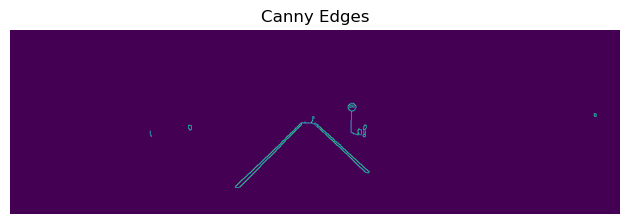

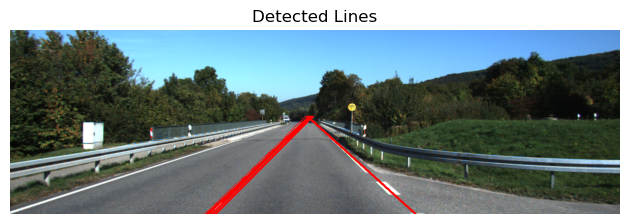

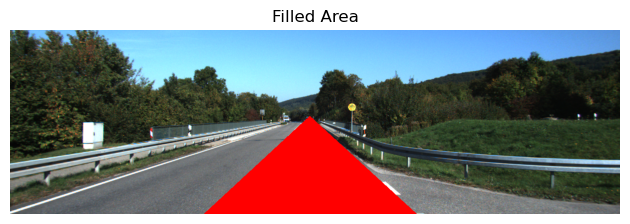

In [32]:
# Use the function to find the lines in the image
# ADD YOUR CODE HERE
threshold = 120  
min_theta = 0
max_theta = 180

# Find lines using the Hough transform
lines1 = hough_lines_new(edges, threshold, min_theta, max_theta)
# Show the image with the lines found
# Suggestions: use the function fill_lines() and show_img()
# ADD YOUR CODE HERE
image_with_lines1, mask= draw_lines(image, lines1, color=[0, 0, 255], thickness=3)

image_filled1 = fill_lines(image, mask, color=[0, 0, 255])

# Display the results
show_img(image,'Original Image')
show_img(edges,'Canny Edges')
show_img(image_with_lines1,'Detected Lines')
show_img(image_filled1,'Filled Area')


---

## Road signs detection using the Hough transform

In this section you will implement the road signs detection using again the Hough transform.

**N.B.** You can use the `cv.HoughCircles()` function (keep in mind that this function includes the edge extraction). Here no need to implement the Hough transform manually, just use openCV in this point.

**N.B.** You can use the `cv.circle()` function to draw the circles on the image (set thickness = -1 to fill the circles).

In [33]:
# Convert the image to uint8 for the Hough transform algorithm
# ADD YOUR CODE HERE
img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
img_uint8 = cv.convertScaleAbs(img_gray)

# Create a window with a set of trackbars to change the parameters of the Hough transform
# Using the trackbars choose the best parameters to find all the circle sign in the image
# ADD YOUR CODE HERE

def nothing(value):
    # Callback function for trackbars
    pass
# window name for displaying circles
name_window_detected_circles = "Detected Circles"
# Create a window with trackbars
cv.namedWindow("Parameter Tuning")
cv.createTrackbar('Param1', 'Parameter Tuning', 600, 2000, nothing)
cv.createTrackbar('Param2', 'Parameter Tuning', 8, 50, nothing)
cv.createTrackbar('Min Radius', 'Parameter Tuning', 5, 50, nothing)
cv.createTrackbar('Max Radius', 'Parameter Tuning', 5, 50, nothing)

while True:
    param1 = cv.getTrackbarPos('Param1', 'Parameter Tuning')
    param2 = cv.getTrackbarPos('Param2', 'Parameter Tuning')
    min_radius = cv.getTrackbarPos('Min Radius', 'Parameter Tuning')
    max_radius = cv.getTrackbarPos('Max Radius', 'Parameter Tuning')

    # Apply HoughCircles
    circles = cv.HoughCircles(img_uint8, cv.HOUGH_GRADIENT, 1,
                               minDist=img_uint8.shape[0] // 64,
                               param1=param1,
                               param2=param2,
                               minRadius=min_radius,
                               maxRadius=max_radius)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            # Draw filled circle
            cv.circle(image, center, radius, (255, 0, 255), thickness=-1)

    cv.imshow(name_window_detected_circles, image)

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cv.destroyAllWindows()


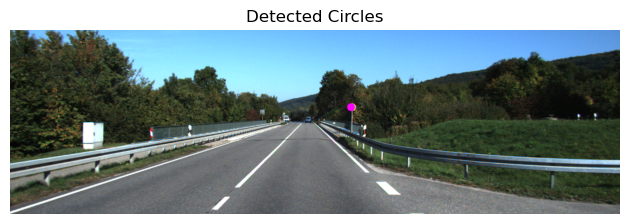

In [34]:
# Visualize the result of the Hough transform with the best parameters
# ADD YOUR CODE HERE
param1 = 700
param2 = 10
min_radius = 8
max_radius = 10

# Apply HoughCircles
circles = cv.HoughCircles(img_uint8, cv.HOUGH_GRADIENT, 1,
                           minDist=img_uint8.shape[0] // 64,
                           param1=param1,
                           param2=param2,
                           minRadius=min_radius,
                           maxRadius=max_radius)

if circles is not None:
    circles = np.uint16(np.around(circles))
    result_image = np.copy(image)  # Create a copy to draw circles on
    for i in circles[0, :]:
        center = (i[0], i[1])
        radius = i[2]
        # Draw filled circle on the result image
        cv.circle(result_image, center, radius, (255, 0, 255), thickness=-1)

    # Display the result image with circles
    show_img(result_image,'Detected Circles')
    cv.waitKey(0)
    cv.destroyAllWindows()